In [ ]:
import h5py
import pickle
import numpy as np
import geopandas as gpd
from glob import glob
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from shapely.geometry import Point
from utils.atl13_readout import read_atl13


In [ ]:
lake_name = 'erhai'
dir_atl13 = 'data/isat2/'+lake_name
paths_atl13 = sorted(glob(dir_atl13 + '/*.h5'))
paths_atl13 = [path for path in paths_atl13 if 'readout' not in path]
path_lake = 'data/lakes-vec/' + lake_name + '_s2_20240801.gpkg'



In [ ]:
lake_vec = gpd.read_file(path_lake)
## inner buffer the lake polygon
lake_vec_shrink = lake_vec.copy()
lon_center = lake_vec_shrink.bounds.mean(axis=1).values
utm_zone = np.floor(lon_center/6)+31
epsg_code = f'326{int(utm_zone[0])}'
lake_vec_shrink = lake_vec_shrink.to_crs(epsg=epsg_code)
lake_vec_shrink['geometry'] = lake_vec_shrink.geometry.buffer(-500)
lake_vec_shrink = lake_vec_shrink.to_crs(epsg=4326)


In [ ]:
path_atl13 = paths_atl13[0]
!h5ls $path_atl13/gt1l 


alpha_mle                Dataset {57705/Inf}
anom_ssegs               Group
atl13refid               Dataset {57705/Inf}
bottom_lat               Dataset {57705/Inf}
bottom_lon               Dataset {57705/Inf}
cloud_flag_asr_atl09     Dataset {57705/Inf}
cloud_flag_atm_atl09     Dataset {57705/Inf}
cycle_number             Dataset {57705/Inf}
delta_time               Dataset {57705/Inf}
err_ht_water_surf        Dataset {57705/Inf}
err_slope_trk            Dataset {57705/Inf}
ht_ortho                 Dataset {57705/Inf}
ht_water_surf            Dataset {57705/Inf}
ice_flag                 Dataset {57705/Inf}
inland_water_body_id     Dataset {57705/Inf}
inland_water_body_region Dataset {57705/Inf}
inland_water_body_size   Dataset {57705/Inf}
inland_water_body_source Dataset {57705/Inf}
inland_water_body_type   Dataset {57705/Inf}
layer_flag_atl09         Dataset {57705/Inf}
met_ts_atl09             Dataset {57705/Inf}
met_wind10_atl09         Dataset {57705/Inf}
met_wind10_atl13        

### 1. atl13 data read out

In [ ]:
for path in paths_atl13:
    path_atl13_readout = path.replace('.h5', '_readout.h5')
    read_atl13(path_in = path, path_out=path_atl13_readout)
    break 


written file: data/isat2/erhai/ATL13_20230118162142_04451801_007_01_readout.h5


In [ ]:
!h5ls $path_atl13_readout


h                        Dataset {819508}
lat                      Dataset {819508}
lon                      Dataset {819508}
t_dyr                    Dataset {819508}


### 2. mask the measurement outside the lake and calculate lake height

In [ ]:
paths_readout = sorted(glob(dir_atl13 + '/*_readout.h5'))
paths_readout.__len__()


20

In [ ]:
def vars_atl13_read(path_readout):
    vars_atl13 = {'lat':[], 'lon':[], 't_dyr':[], 'h':[]}
    with h5py.File(path_readout,'r') as atl13_readout:
    # for beam in beams:
        vars_atl13['lat'] = atl13_readout['lat'][:]
        vars_atl13['lon'] = atl13_readout['lon'][:]
        vars_atl13['t_dyr'] = atl13_readout['t_dyr'][:]
        vars_atl13['h'] = atl13_readout['h'][:]
    return vars_atl13

vars_atl13 = vars_atl13_read(paths_readout[0])
print(vars_atl13['h'].shape)


(819508,)


In [ ]:
extent = [lake_vec_shrink.bounds.minx[0]-0.1, lake_vec_shrink.bounds.maxx[0]+0.1, 
          lake_vec_shrink.bounds.miny[0]-0.1, lake_vec_shrink.bounds.maxy[0]+0.1]


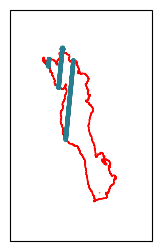

In [20]:
## check the atl13 data
fig, ax = plt.subplots(1,1, figsize=(3, 3), 
                       subplot_kw={'projection': ccrs.PlateCarree()}   )
ax.set_extent(extent, crs=ccrs.PlateCarree())
lake_vec.plot(ax=ax, facecolor="none", edgecolor='red')
ax.scatter(x=vars_atl13['lon'], y=vars_atl13['lat'], c=vars_atl13['h'], s=3.5)


In [21]:
### remove the measurement outside the lake
def vars_mask(vars_in):
    vars_masked = {'lat':[], 'lon':[], 't_dyr':[], 'h':[]}
    ids_lake = np.zeros(shape=(vars_in['lon'].shape))
    for i, lon in enumerate(vars_in['lon']):
        point = Point(lon, vars_in['lat'][i])
        if lake_vec_shrink.geometry[0].contains(point):
            ids_lake[i]=1
    for key in vars_in.keys():
        vars_masked[key] = vars_in[key][ids_lake==1]
    return vars_masked

vars_atl13_masked = vars_mask(vars_in=vars_atl13)
print(vars_atl13_masked['h'].shape)


(1080,)


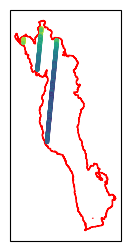

In [22]:
fig, ax = plt.subplots(1,1, figsize=(3, 3), 
                       subplot_kw={'projection': ccrs.PlateCarree()}   )
lake_vec.plot(ax=ax, facecolor="none", edgecolor='red')
ax.scatter(x=vars_atl13_masked['lon'], 
           y=vars_atl13_masked['lat'], 
           c=vars_atl13_masked['h'], 
           s=3.5)

water height: 1965.72 m, time: 2023.05 day of year


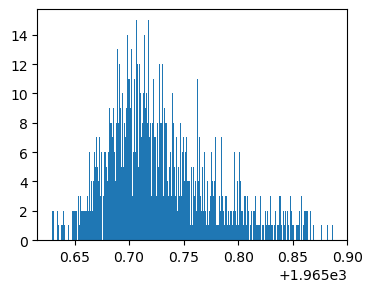

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4, 3))
ax.hist(vars_atl13_masked['h'], bins=300);
ht_water = np.median(vars_atl13_masked['h'])
ht_time = vars_atl13_masked['t_dyr'].mean()
print(f'water height: {ht_water:.2f} m, time: {ht_time:.2f} day of year')


### 3. batch processing for the readout data

In [24]:
lake_heights = {'date':[], 'height':[]}
for path_readout in paths_readout:
    print(f'processing: {path_readout}')
    vars_atl13 = vars_atl13_read(path_readout)
    vars_atl13_masked = vars_mask(vars_in=vars_atl13)
    if vars_atl13_masked['h'].shape[0] == 0: 
        print('no measurement, skip')
        continue 
    ht_water = float(np.mean(vars_atl13_masked['h']))
    ht_time = float(vars_atl13_masked['t_dyr'].mean())
    lake_heights['date'].append(ht_time)
    lake_heights['height'].append(ht_water)
    # break

print(lake_heights)


processing: data/isat2/erhai/ATL13_20230118162142_04451801_007_01_readout.h5


processing: data/isat2/erhai/ATL13_20230205053131_07131801_007_01_readout.h5
processing: data/isat2/erhai/ATL13_20230419120124_04451901_007_01_readout.h5
processing: data/isat2/erhai/ATL13_20230507011110_07131901_007_01_readout.h5
processing: data/isat2/erhai/ATL13_20230707190555_02692001_007_01_readout.h5
no measurement, skip
processing: data/isat2/erhai/ATL13_20230719074046_04452001_007_01_readout.h5
no measurement, skip
processing: data/isat2/erhai/ATL13_20230805205021_07132001_007_01_readout.h5
no measurement, skip
processing: data/isat2/erhai/ATL13_20230817030808_08852001_007_01_readout.h5
no measurement, skip
processing: data/isat2/erhai/ATL13_20231018032018_04452101_007_01_readout.h5
processing: data/isat2/erhai/ATL13_20231104163001_07132101_007_01_readout.h5
processing: data/isat2/erhai/ATL13_20231115224748_08852101_007_02_readout.h5
no measurement, skip
processing: data/isat2/erhai/ATL13_20240105102503_02692201_007_01_readout.h5
no measurement, skip
processing: data/isat2/erha

Text(0, 0.5, 'Height (m)')

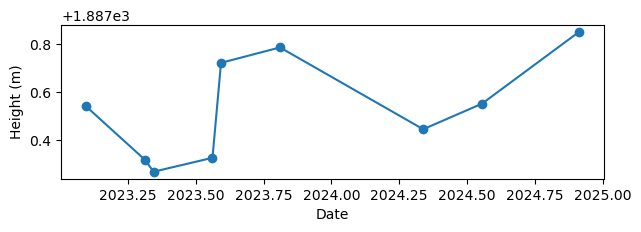

In [21]:
fig, ax = plt.subplots(1,1, figsize=(7, 2))
ax.plot(lake_heights['date'], lake_heights['height'], '-o')
ax.set_xlabel('Date')
ax.set_ylabel('Height (m)')


In [22]:
## ### save to pkl data 
path_save = dir_atl13+'/'+lake_name+'_wse_isat2.pkl'
lake_heights_dict = dict(zip(lake_heights['date'], lake_heights['height']))
with open(path_save, 'wb') as f:
       pickle.dump(lake_heights_dict, f)

